# Chavas (2015) profile fit on SAR data
The SAR data grid is already centered on the TC center found by the method of Léo.

We use a Chavas wind profile, as presented by Chavas et al. in their paper of 2015. Inner and outer solutions are defined by implicit equations that are solved numerically to fit on the observations. Given an observation of Vfit at a radius of Rfit (Rfit can be any radius, to allow for observations other than at Rmax), the code is initialized with a first guess of Rmax, and a solution for the inner profile (ER11) is iteratively computed. Then, a solution for the outer profile (E04) is computed and merged at a merging point that is also computed (it is defined as the intersection point of the 2 models). The merging point is computed by updating the r0 of the E04 model until this profile intersects the inner solution ER11 in a single point. Once E04 is computed and compatible (intersects) with ER11, the merged solution is computed and compared with the observation of Vfit at Rfit. Then, the Rmax of the merged profile (actually it is the Rmax of the inner solution) is updated with respect to this comparison. Then the whole process is repeated. We can re-write the whole code with the following pseudo-code:


------------------------------------------------------------------------------


Inputs: $ Vmax, Rfit, Vfit $ as well as other parameters ($ f, Cd, Ck, Wcool $)

Initialize with a first guess of $ Rmax $ through the ratio $ \frac{Rmax}{Rfit} $;
> While our estimate of $ \frac{Rmax}{Rfit} $ is too far from observed $ \frac{Rmax}{Rfit} $:
>> Using this $ Rmax = \frac{Rmax}{Rfit} * Rfit $ and the input $ Vmax $, compute the inner solution VV_ER11;


>> Initialize with a first guess of $ R0 $ through the ratio $ \frac{Rmax}{R0} $;


>> While error on $ \frac{Rmax}{R0} $ is too large:
>>> Using this $ R0 = Rmax * (\frac{Rmax}{R0})^{-1}$, compute the outer solution M0_E04 (in (M, r) - space);


>>> Update $ R0 $ until this outer solution intersects the inner solution VV_ER11 in exactly one point (which will be defined as the merging point);


>> Compute the merged solution (in (M, r) - space);


>> Using the previously computed $ R0 $ and the merged profile, compare with the observation $ Vfit $ at $ Rfit $ (actually in the code it is $ \frac{Rfit}{R0} $ and $ \frac{Mfit}{M0} $ that are used for the comparison step); Then convert* this to an error on $ \frac{Rmax}{Rfit} $;


>> Update $ Rmax $ (actually $ \frac{Rmax}{Rfit} $) using this error; If the error is small enough the *while loop* stops.


> Return the computed profile, as well as the computed $ Rmax, R0, Rmerge $, and $ Vmerge $.

------------------------------------------------------------------------------

<span>&#42;</span> For instance, if the input (=observed) $ \frac{Mfit}{M0} $ is larger than the computed $ \frac{Mfit}{M0} $ it means that the $ Rmax $ used for the computation should be smaller, so we update it accordingly. This can be visualized on an (M, r) - plane.


Note also that Chavas et al are working with the azimuthal-mean azimuthal wind speed in their paper. But one could also check if their profile fits total wind speed data. Both options are testable in the present code.





In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.integrate import odeint

import functions as f

In [2]:
### PATHS
# dir_path  = '/home/arthur/data/cyclobs/ggd/'
dir_path  = '/home/arthur/data/cyclobs/rotated_files/'
# file_path = 's1b-iw-owi-cm-20170923t104349-20170923t104554-000003-00D45F_ll_gd_rotated.nc'
# file_path = 'rs2--owi-cm-20120928t095127-20120928t095327-00003-BDBE0_ll_gd_rotated.nc'
# NAN BUG (because no wind speed value after r = 400 km, we have to stop the dataset there) file_path = 'rs2--owi-cm-20130701t104119-20130701t104235-00003-79BFE_ll_gd_rotated.nc'
# file_path = 's1a-ew-owi-cm-20180201t132219-20180201t132527-000003-022E2F_ll_gd_rotated.nc'

# Compare with Alexis'
# file_path = 's1a-ew-owi-cm-20180808t041303-20180808t041507-000003-0283BF_ll_gd_rotated.nc' # 2
# file_path = 's1a-ew-owi-cm-20180807t154302-20180807t154506-000003-028386_ll_gd_rotated.nc' # 3
# file_path = 's1a-ew-owi-cm-20180818t150300-20180818t150604-000003-0288C3_ll_gd_rotated.nc' # 4
# file_path = 's1a-ew-owi-cm-20180819t032959-20180819t033303-000003-0288F7_ll_gd_rotated.nc' # 5
# file_path = 's1a-ew-owi-cm-20190731t034721-20190731t034910-000003-033442_ll_gd_rotated.nc' # 6
# file_path = 's1b-ew-owi-cm-20180810t165606-20180810t165822-000003-0167B7_ll_gd_rotated.nc' # 7

# Compare with Flora's
file_path = 's1a-ew-owi-cm-20180818t150300-20180818t150604-000003-0288C3_ll_gd_rotated.nc'

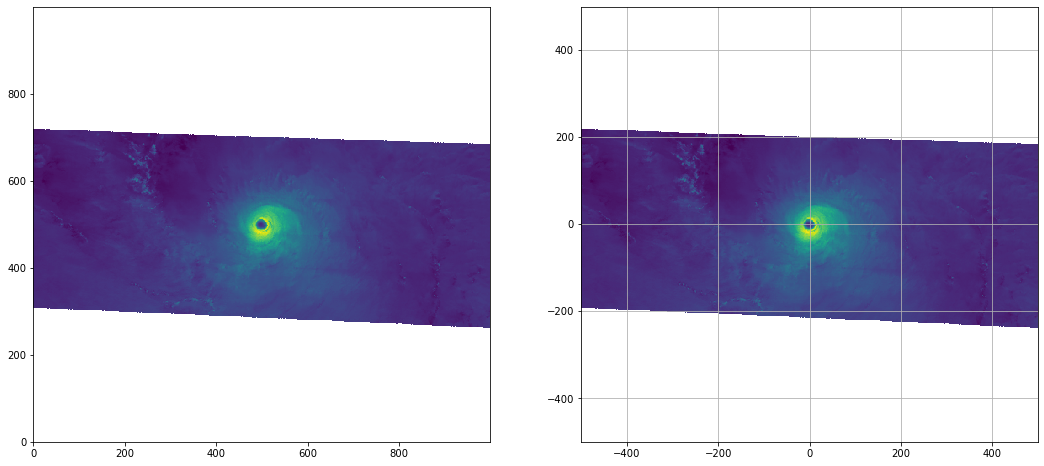

In [3]:
### OPEN AND PRINT
ds = xr.open_dataset(dir_path + file_path)
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.pcolormesh(ds['x'], ds['y'], ds['wind_speed'])
plt.subplot(1, 2, 2)
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed']);plt.grid()

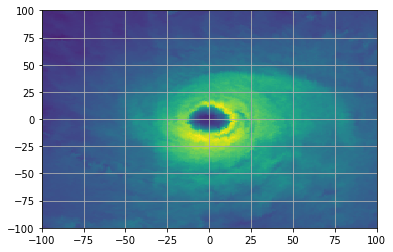

In [4]:
### TEST
plt.pcolormesh(ds['x_coords'], ds['y_coords'], ds['wind_speed'])
plt.axis([-100,100,-100,100]);plt.grid()

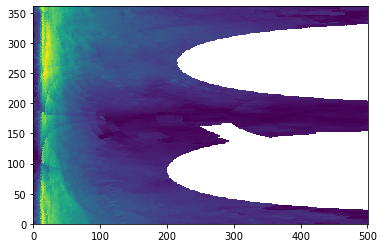

In [5]:
### DEFINE (r, theta) GRID
r     = np.arange(501)
th    = np.arange(361)
r, th = np.meshgrid(r, th)
ds_r  = np.array(ds['r_polar'])
ds_th = np.mod(np.array(ds['theta']) * 180. / np.pi, 360) # convert theta from radians to degrees

# =====> First option: Work with the total wind; this is NOT what Chavas et al. do in their paper
ds_tws = np.array(ds['wind_speed'])

# =====> Second option: Work with the azimuthal-mean azimuthal wind; this is what Chavas et al. do in their paper
ds_aws = np.abs(np.array(ds['tangential_wind'])) # normed azimuthal wind
ds_ws  = np.multiply(ds_tws, ds_aws)             # azimuthal wind

# =====> By default the tangential wind speed is used
spd   = griddata((ds_r.flatten(), ds_th.flatten()), ds_ws.flatten(), (r, th), method='nearest') # Change ds_ws to ds_tws to work with total wind
radius= np.arange(501) + .0001  # to avoid having both r = 0 and n < 0 during fitting process
spdm  = np.nanmean(spd, axis=0) # azimuthal-mean azimuthal wind

plt.pcolormesh(spd)

In [6]:
'''
aw = ds['tangential_wind']
tw = ds['wind_speed']

ds_tws = np.array(ds['wind_speed'])
print("tws:", ds_tws[500:600, 500:600])
ds_ws = np.abs(np.array(ds['tangential_wind']))
print('aw:', ds_ws[500:600, 500:600])
result = np.multiply(ds_tws, ds_ws)
print('result:', result.shape)
print(result[500:600, 500:600])
'''

'\naw = ds[\'tangential_wind\']\ntw = ds[\'wind_speed\']\n\nds_tws = np.array(ds[\'wind_speed\'])\nprint("tws:", ds_tws[500:600, 500:600])\nds_ws = np.abs(np.array(ds[\'tangential_wind\']))\nprint(\'aw:\', ds_ws[500:600, 500:600])\nresult = np.multiply(ds_tws, ds_ws)\nprint(\'result:\', result.shape)\nprint(result[500:600, 500:600])\n'

In [7]:
### STORM PARAMETERS (Vmax, Vfit, Rfit, and Lat)
Vmax = np.max(spdm[:100])                      #[ms-1] {50} maximum azimuthal-mean wind speed
Vfit = 17                                      #[ms-1] {12} wind speed at Rfit
Rmax = np.argmax(spdm[:100])                   #To compute Rfit
diff = np.abs(spdm - Vfit)                     #To compute Rfit
Rfit = (np.argmin(diff[Rmax:]) + Rmax) * 1000  #[m] {300*1000} a wind radius
print("Rfit =", Rfit)
Lat  = np.float(ds['lat_ref'])                 #[°]         latitude of storm center

### DEFAULT PARAMETERS
fcor = f.coriolis(Lat)         #[s-1]  {5e-5} Coriolis parameter at storm center

### ENVIRONMENTAL PARAMETERS
# Outer region
Cdvary    = 1                  #[-]    {1} 0 : Outer region Cd = constant (defined on next line) 1 : Outer region Cd = f(V) (empirical 	Donelan et al. 2004)
Cd        = 1.5e-3             #[-]    {1.5e-3} ignored if Cdvary = 1 surface momentum exchange (i.e. drag) coefficient
w_cool    = 2/1000             #[ms-1] {2/1000 Chavas et al 2015} radiative-subsidence rate in the rain-free tropics above the boundary layer top
# Inner region
CkCdvary  = 1                  #[-]    {1} 0 : Inner region Ck/Cd = constant (defined on next line) 1 : Inner region Ck/Cd = f(Vmax) (empirical Chavas et al. 2015)
CkCd      = 1                  #[-]    {1} ignored if CkCdvary = 1 ratio of surface exchange coefficients of enthalpy and momentum capped at 1.9 (things get weird >=2)
# Eye adjustment
eye_adj   = 0                  #[-]    {1} 0 = use ER11 profile in eye 1 = empirical adjustment
alpha_eye = .15                #[-]    {.15 empirical Chavas et al 2015} V/Vm in eye is reduced by factor (r/rm)^alpha_eye ignored if eye_adj=0

Rfit = 88000


<ipython-input-7-b751527d01f9>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Lat  = np.float(ds['lat_ref'])                 #[°]         latitude of storm center


/home/arthur/scripts/windProfiles/symmetric/functions.py:289: RuntimeWarning: divide by zero encountered in true_divide
  V_ER11 = (1. / rr_ER11) * (Vmax * rmax + .5 * fcor * rmax ** 2) * ((2 * (rr_ER11 / rmax) ** 2) / (2 - CkCd + CkCd * (rr_ER11 / rmax) ** 2)) ** (1 / (2 - CkCd)) - .5 * fcor * rr_ER11
/home/arthur/scripts/windProfiles/symmetric/functions.py:289: RuntimeWarning: invalid value encountered in multiply
  V_ER11 = (1. / rr_ER11) * (Vmax * rmax + .5 * fcor * rmax ** 2) * ((2 * (rr_ER11 / rmax) ** 2) / (2 - CkCd + CkCd * (rr_ER11 / rmax) ** 2)) ** (1 / (2 - CkCd)) - .5 * fcor * rr_ER11


(4598,)


/home/arthur/scripts/windProfiles/symmetric/functions.py:203: RuntimeWarning: invalid value encountered in true_divide
  VV = (Mm / rmax) * (MMfracMm / rrfracrm) - .5 * fcor * rmax * rrfracrm #[ms-1]


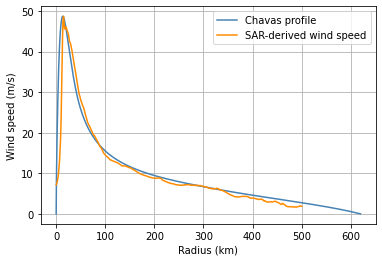

In [8]:
### FITTING THE PROFILE
rr, VV, rmax, r0, rmerge, Vmerge = f.ER11E04_nondim_rfitinput(Vmax, Rfit, Vfit, fcor, Cdvary, Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye)

print(rr.shape)

### PRINTING THE FIT # !!!! INVERSE COLORS THAN OTHER PROFILES !!!!!####!!////
fig1 = plt.plot(rr / 1000., VV, color='steelblue', label='Chavas profile')            # V_fit
fig2 = plt.plot(radius, spdm,   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()

In [9]:
print(rr.shape)
print(VV.shape)
print(radius.shape)
print(spdm.shape)

(4598,)
(4598,)
(501,)
(501,)


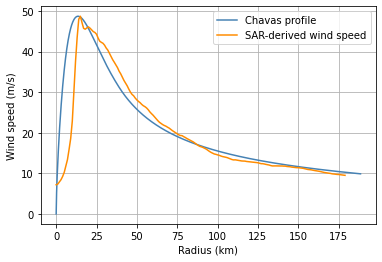

In [10]:
### SMALLER SCALE
fig1 = plt.plot(rr[:1400] / 1000., VV[:1400], color='steelblue', label='Chavas profile')            # V_fit
fig2 = plt.plot(radius[:180], spdm[:180],   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()

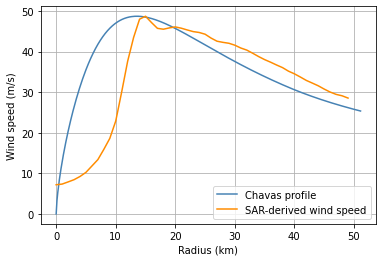

In [11]:
### EVEN SMALLER SCALE
fig1 = plt.plot(rr[:380] / 1000., VV[:380], color='steelblue', label='Chavas profile')          # V_fit
fig2 = plt.plot(radius[:50], spdm[:50],   color='darkorange',  label='SAR-derived wind speed')  # V_obs
plt.xlabel('Radius (km)')
plt.ylabel('Wind speed (m/s)')
plt.legend();plt.grid()
# plt.savefig('profil.png')
plt.show()

In [12]:
print(ds)

<xarray.Dataset>
Dimensions:                             (lat: 1000, lon: 1000, x: 1000, y: 1000)
Coordinates:
    x_coords                            (x, y) int64 -500 -499 -498 ... 498 499
    y_coords                            (x, y) int64 -500 -500 -500 ... 499 499
    r_polar                             (x, y) float64 707.1 706.4 ... 705.7
    theta                               (x, y) float64 -2.356 -2.355 ... 0.7854
    lon_coords                          (lon, lat) float64 ...
    lat_coords                          (lon, lat) float64 ...
Dimensions without coordinates: lat, lon, x, y
Data variables:
    nrcs_detrend_cross                  (x, y) float32 ...
    mask_flag                           (x, y) float32 ...
    incidence_angle                     (x, y) float32 ...
    nrcs_detrend_co                     (x, y) float32 ...
    nrcs_co                             (x, y) float32 ...
    heading_angle                       (x, y) float32 ...
    wind_speed               